In [1]:
def set_paths():

    import os
    import sys

    USECASES_SRC = os.path.join(os.environ.get('BDA_USER_HOME', ''), "repositorios", "use-cases")
    if USECASES_SRC not in sys.path:
        sys.path.append(USECASES_SRC)


set_paths()


In [2]:
from churn_nrt.src.utils.spark_session import get_spark_session

sc, spark, sql_context=get_spark_session(app_name="affinity_churn_combination")

### Leo predicciones del modelo de afinidad y del modelo general de churn

In [3]:
churn_general=spark.read.load('/data/attributes/vf_es/model_outputs/model_scores/model_name=churn_mobile/year=2019/month=12/day=31')

In [4]:
churn_comp=spark.read.load('/data/udf/vf_es/churn/churn_competitor_model/v2/multiclase/pred_20191231_production')

### Etiqueto con las portabilidades a dos meses

In [5]:
from churn_nrt.src.data.sopos_dxs import MobPort
from pyspark.sql.functions import when, col

portab_table = (  # MobPort new
            MobPort(spark, churn_window=60)
                .get_module('20191231', save=False, save_others=False, force_gen=True)
                .select("msisdn", "target_operator")
        ) 

churn_comp = churn_comp.join(portab_table, on="msisdn", how="left").fillna(
            "none")  # label customer base: join with portouts and replace NA by 'none' (customers who do not churn)



[DataTemplate] __init__ | module name = mob_port/60 | path = /data/udf/vf_es/churn_nrt/mob_port/60 | verbose = True
[DataTemplate] get_module | module mob_port/60 - for closing_day=20191231 save=False save_others=False force_gen=True
[DataTemplate] get_module | args: () | kwargs: {}
[MobPort] check_valid_params | Params ok
[DataTemplate] get_module | Module will be generated since force_gen parameter was set to True. An existing module in path will be ignored
[MobPort] check_valid_params | Params ok
[Info get_mobile_portout_requests] - Port-out requests for mobile services during period 20191231-20200229: 336757
[DataTemplate] get_module | module 'mob_port/60' | Elapsed time in build_module function: 0.841794816653 minutes
[DataTemplate] get_module | module 'mob_port/60' | Module will not be saved (save=False and is_default_module()=True)


### Creo un label por operador

In [6]:
churn_comp=churn_comp.withColumn('label_masmovil',when(col('target_operator')=="masmovil", 1.0).otherwise(0.0)) \
                     .withColumn('label_movistar',when(col('target_operator')=="movistar", 1.0).otherwise(0.0)) \
                     .withColumn('label_orange',when(col('target_operator')=="orange", 1.0).otherwise(0.0)) \
                     .withColumn('label_others',when(col('target_operator')=="others", 1.0).otherwise(0.0))
                        

In [7]:
churn_comp=churn_comp.select('msisdn','label_masmovil',
                             'label_movistar','label_orange',
                            'label_others','prediction')

In [8]:
churn_general=churn_general.select('msisdn','scoring')

### Hago un join del modelo general de churn y de afinidad

In [9]:
union=churn_comp.join(churn_general,on='msisdn',how='inner')

### Sacamos scoring resultante de la combinación del modelo de churn y el de afinidad para cada operador

score_churn_masmovil sería igual al score del modelo general de churn para los msisdn marcados como masmovil por el modelo de afinidad y 0 para el resto

In [10]:
union=union.withColumn('score_masmovil',when(col('prediction')=='masmovil',col('scoring')).otherwise(0.0)) \
           .withColumn('score_movistar',when(col('prediction')=='movistar',col('scoring')).otherwise(0.0)) \
           .withColumn('score_orange',when(col('prediction')=='orange',col('scoring')).otherwise(0.0)) \
           .withColumn('score_others',when(col('prediction')=='others',col('scoring')).otherwise(0.0))

### Cargo las predicciones del modelo específico de churn por operador

In [11]:
masmovil=spark.read.load('/data/attributes/vf_es/model_outputs/model_scores/model_name=churn_mobile_masmovil/year=2019/month=12/day=31').select('msisdn','scoring').withColumnRenamed('scoring','score_model_masmovil')
movistar= spark.read.load('/data/attributes/vf_es/model_outputs/model_scores/model_name=churn_mobile_movistar/year=2019/month=12/day=31').select('msisdn','scoring').withColumnRenamed('scoring','score_model_movistar')
orange= spark.read.load('/data/attributes/vf_es/model_outputs/model_scores/model_name=churn_mobile_orange/year=2019/month=12/day=31').select('msisdn','scoring').withColumnRenamed('scoring','score_model_orange')
others=spark.read.load('/data/attributes/vf_es/model_outputs/model_scores/model_name=churn_mobile_others/year=2019/month=12/day=31').select('msisdn','scoring').withColumnRenamed('scoring','score_model_others')

### Creo tablón de predicciones conjunto, que contenga tanto los scores resultantes de la combinación del modelo afinidad  + churn, como los scores específicos del modelo por operador, como los labels reales

preds_df: msisdn, score_masmovil (construido con afinidad), score_model_masmovil (construido con modelo específico), label_ masmovil (1,0)

In [12]:
preds_df=union.join(masmovil,on='msisdn',how='inner')
preds_df=preds_df.join(movistar,on='msisdn',how='inner')
preds_df=preds_df.join(orange,on='msisdn',how='inner')
preds_df=preds_df.join(others,on='msisdn',how='inner')

### Dibujo curvas lift modelo específico - modelo afinidad + churn de cada operador y las comparo

In [13]:
preds_df.cache()

DataFrame[msisdn: string, label_masmovil: double, label_movistar: double, label_orange: double, label_others: double, prediction: string, scoring: double, score_masmovil: double, score_movistar: double, score_orange: double, score_others: double, score_model_masmovil: double, score_model_movistar: double, score_model_orange: double, score_model_others: double]

In [14]:
preds_df.count()

4828475

In [29]:
from churn_nrt.src.projects_utils.models.modeler import get_cumulative_churn_rate_fix_step
import matplotlib.pyplot as plt

lift_affinity = get_cumulative_churn_rate_fix_step(spark, preds_df, step_ = 1/1000.0, ord_col ="score_others", label_col ="label_others", verbose = False, noise = 0.000001)
lift_model = get_cumulative_churn_rate_fix_step(spark, preds_df, step_ = 1/1000.0, ord_col ="score_model_others", label_col ="label_others", verbose = False, noise = 0.000001)
lift_affinity_pd = lift_affinity.select('cum_volume_for_capture', 'cum_captured_churn').toPandas()
lift_model_pd = lift_model.select('cum_volume_for_capture', 'cum_captured_churn').toPandas()



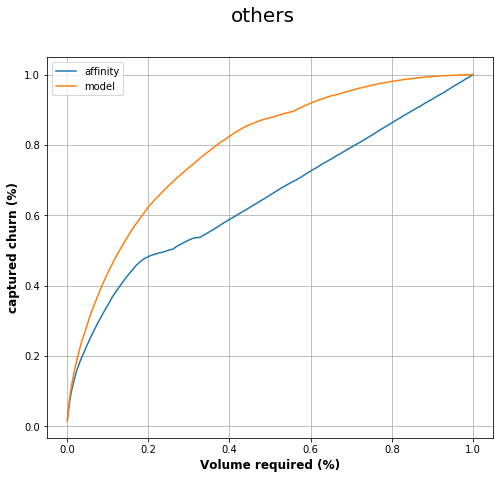

In [30]:
fig,ax = plt.subplots(figsize=(8,7))
font={'fontsize':12, 'fontweight': 'bold'}
ax.plot(lift_affinity_pd.cum_volume_for_capture, lift_affinity_pd.cum_captured_churn, label = 'affinity')
ax.plot(lift_model_pd.cum_volume_for_capture, lift_model_pd.cum_captured_churn, label = 'model')
ax.set_xlabel("Volume required (%)", fontdict = font)
ax.set_ylabel("captured churn (%)", fontdict = font)
ax.legend(loc='best')
fig.suptitle('others', fontsize=20)
ax.grid(True)